In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import util
import warnings
warnings.filterwarnings(action='once')

## User Params

In [3]:
basepath = Path('/home/jupyter/data')
dataset_name = 'cifar10'
n_epoch = 100

## Derived Params and Helpers

In [4]:
path_img = basepath/'imagenet_style'/dataset_name
labels_file = basepath/dataset_name/'labels.csv'


In [5]:
def create_learner(data, savename='dummy', patience=3, modeltype=models.resnet34):
    learn = create_cnn(data, 
                       modeltype, 
                       metrics=error_rate, 
                       callback_fns=[partial(SaveModelCallback, name=savename), 
                                     partial(EarlyStoppingCallback, patience=patience),
                                     ShowGraph])   
    return learn

## Create dataset

In [6]:
data = ImageDataBunch.from_folder(path_img, 
                                  train='train', 
                                  valid='valid', 
                                  test='test', 
                                  ds_tfms=get_transforms(), 
                                  size=224)
data.normalize(imagenet_stats)

In [7]:
print(data.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Display dataset

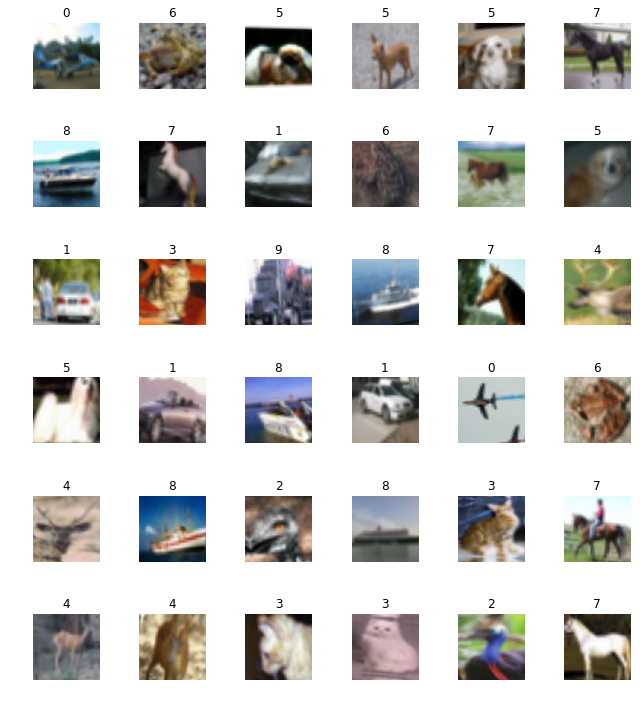

In [8]:
data.show_batch(rows=6)

## Train a standard transfer learning model (stage 1)

epoch,train_loss,valid_loss,error_rate
1,0.693264,0.440413,0.141965
2,0.452804,0.294945,0.101789
3,0.352348,0.218818,0.075962
4,0.295217,0.189086,0.067860
5,0.259569,0.170856,0.062458
6,0.244948,0.163181,0.058744
7,0.227566,0.153269,0.054186
8,0.195051,0.151184,0.053511
9,0.204607,0.141121,0.050979
10,0.205141,0.141237,0.050810


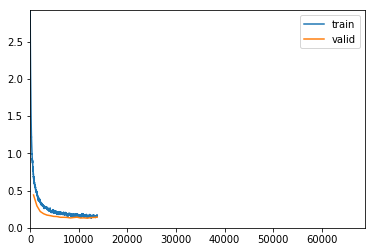

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/opt/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.6/

KeyboardInterrupt: 

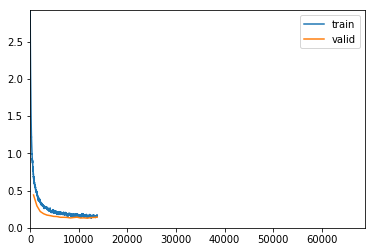

In [93]:
learn = create_learner(data, 'stage1-bestmodel')
learn.fit_one_cycle(n_epoch)

### Show results from generic evaluation tool

In [12]:
learn.load('stage1-bestmodel')

In [13]:
results_val = util.eval_rollup(labels_file, learn, evalset='val')

/home/jupyter/tutorials/util.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_keep['name'] = [d.split('/')[-1] for d in df_keep.name.tolist()]


Dataset: val
{'sklearn': {'acc': 0.9567859554355166,
             'auc_avg': 0.998736490464441,
             'auc_indiv': array([0.998904, 0.999731, 0.998863, 0.995332, 0.999082, 0.99739 , 0.999459, 0.999228, 0.999745, 0.999631]),
             'confmat': array([[584,   3,   1,   2, ...,   1,   0,  10,   1],
       [  2, 557,   0,   0, ...,   0,   0,   1,  11],
       [  5,   0, 574,   5, ...,  10,   1,   0,   0],
       [  0,   0,   7, 531, ...,   6,   3,   1,   0],
       ...,
       [  3,   0,   3,   5, ..., 608,   0,   0,   0],
       [  3,   0,   0,   4, ...,   2, 539,   1,   0],
       [  7,   0,   3,   0, ...,   0,   0, 565,   1],
       [  6,  15,   0,   0, ...,   1,   0,   4, 595]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '          0       0.96      0.97      0.96       604\n'
                       '          1       0.97      0.98      0.97       571\n'
                       '       

In [14]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.9535,
             'auc_avg': 0.9985687111111112,
             'auc_indiv': array([0.99928 , 0.999608, 0.998381, 0.995052, 0.998936, 0.996771, 0.999608, 0.999187, 0.999609, 0.999256]),
             'confmat': array([[963,   2,   6,   4, ...,   0,   0,  25,   0],
       [  2, 976,   0,   0, ...,   0,   0,   3,  19],
       [  5,   0, 941,  17, ...,  13,   2,   1,   0],
       [  1,   0,   5, 898, ...,  14,   2,   2,   2],
       ...,
       [  2,   0,   7,   9, ..., 978,   0,   0,   0],
       [  3,   0,   3,   5, ...,   0, 949,   0,   1],
       [ 10,   4,   1,   0, ...,   0,   0, 981,   4],
       [  5,  23,   2,   0, ...,   1,   1,   6, 961]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '          0       0.97      0.96      0.97      1000\n'
                       '          1       0.97      0.98      0.97      1000\n'
                       '          2      

### Show results using FastAI to confirm matches

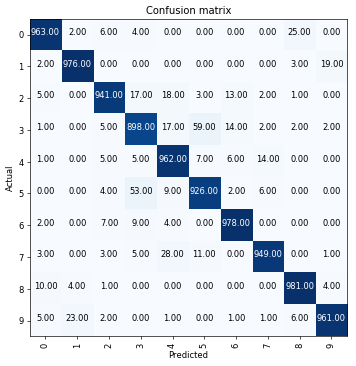

In [15]:
# Confirm fastai reporting matching the generic one used for other platforms
# Some formatting work needed below to run on test and not validation dataset
y_true_num = tensor([data.classes.index(z) for z in y_true])  # Convert strings to numbers (tensor)
preds,y,losses = learn.get_preds(with_loss=True, is_test=True)
interp = ClassificationInterpretation(data, preds, tensor(y_true_num), losses)
#interp.plot_top_losses(15, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

Fastai confusion matrix matches the generic one for the test dataset.

## Unfreezing, fine-tuning, and learning rates

First let's try just unfreezing the previously trained model and continue running some more training to see how well it can do.

epoch,train_loss,valid_loss,error_rate
1,0.191492,0.170335,0.054862
2,0.200750,0.177074,0.061783
3,0.207736,0.175903,0.058913


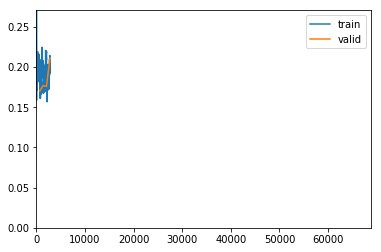

Epoch 4: early stopping


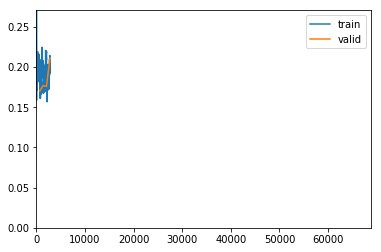

In [16]:
learn = create_learner(data, 'unfreeze-bestmodel')
learn.load('stage1-bestmodel')
learn.unfreeze()
learn.fit_one_cycle(n_epoch)

In [ ]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.9398,
             'auc_avg': 0.9980202055555555,
             'auc_indiv': array([0.998978, 0.999298, 0.998032, 0.99318 , 0.998402, 0.996254, 0.999295, 0.998912, 0.999332, 0.998519]),
             'confmat': array([[979,   2,   0,   2, ...,   2,   2,   4,   6],
       [  1, 965,   0,   0, ...,   0,   0,   1,  33],
       [ 39,   0, 887,  19, ...,  13,   7,   1,   0],
       [  7,   0,   3, 824, ...,   4,  13,   3,   5],
       ...,
       [  2,   0,   3,  20, ..., 961,   1,   0,   0],
       [  3,   0,   2,   2, ...,   2, 966,   0,   1],
       [ 45,   4,   1,   1, ...,   1,   0, 932,  15],
       [  0,  17,   1,   1, ...,   1,   0,   3, 977]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '          0       0.91      0.98      0.94      1000\n'
                       '          1       0.98      0.96      0.97      1000\n'
                       '          2      

## Unfreeze but use identified learning rates

Now let's go back to the original model that only trained the head again. 
But this time, we'll find the best learning rate to use for this, and then use those learning rates with the unfrozen model.

First, find and plot the learning rates using lr_find.

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


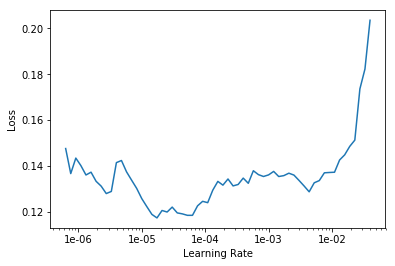

In [ ]:
learn = create_learner(data)
learn.load('stage1-bestmodel')
learn.callback_fns = [Recorder]  # Need to flush callbacks or else lr_find crashes    
learn.lr_find()
learn.recorder.plot()

Now that we have the learning rate range, let's feed that into the model and rerun

Total time: 10:38
epoch  train_loss  valid_loss  error_rate
1      0.605113    0.422258    0.145172    (10:37)



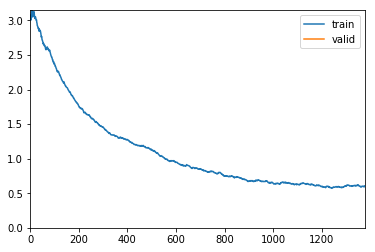

In [13]:
#learn.fit_one_cycle(1)

In [ ]:
# Reload with new savename
learn = create_learner(data, 'stage2-bestmodel')
learn.load('stage1-bestmodel')

epoch,train_loss,valid_loss,error_rate
1,0.138635,0.119803,0.042032
2,0.113005,0.113695,0.037137
3,0.107512,0.108941,0.036462
4,0.090042,0.103648,0.032917


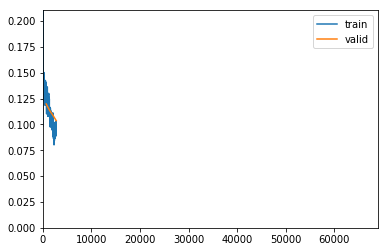

In [ ]:
# Unfreeze and kick off 
learn.unfreeze()
learn.fit_one_cycle(n_epoch, max_lr=slice(1e-5,1e-3))

In [14]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

/home/jupyter/tutorials/util.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_keep['name'] = [d.split('/')[-1] for d in df_keep.name.tolist()]


Dataset: test
{'sklearn': {'acc': 0.8528,
             'auc_avg': 0.9879647555555555,
             'auc_indiv': array([0.990397, 0.997376, 0.981696, 0.965828, 0.986759, 0.981054, 0.992647, 0.992062, 0.99578 , 0.996049]),
             'confmat': array([[834,  11,  20,   9, ...,   8,  15,  59,  21],
       [ 14, 928,   0,   2, ...,   2,   2,   3,  47],
       [ 35,   0, 806,  32, ...,  43,  11,   5,   1],
       [  9,   2,  41, 682, ...,  59,  26,   6,   8],
       ...,
       [  3,   0,  33,  33, ..., 912,   4,   2,   0],
       [  9,   1,  11,  23, ...,   7, 882,   1,   3],
       [ 34,  14,   6,   8, ...,   5,   0, 911,  19],
       [ 15,  36,   2,   7, ...,   2,   5,  13, 920]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '          0       0.87      0.83      0.85      1000\n'
                       '          1       0.93      0.93      0.93      1000\n'
                       '          2      

## Try Resnet50

In [15]:
data = ImageDataBunch.from_folder(path_img, 
                                  train='train', 
                                  valid='valid', 
                                  test='test', 
                                  ds_tfms=get_transforms(), 
                                  size=299,
                                  bs=32)
data.normalize(imagenet_stats)

### Try training just the head

Total time: 1:07:30
epoch  train_loss  valid_loss  error_rate
1      0.391334    0.258425    0.090142    (22:47)
2      0.274642    0.163092    0.057731    (22:20)
3      0.190422    0.134341    0.047941    (22:21)



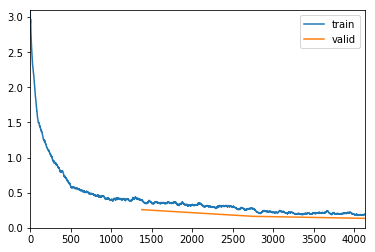

In [16]:
learn = create_learner(data, 'resnet50-stage1-bestmodel', modeltype=models.resnet50)
learn.fit_one_cycle(3)

In [17]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.95,
             'auc_avg': 0.9984433555555556,
             'auc_indiv': array([0.999131, 0.999399, 0.997834, 0.995108, 0.998803, 0.996928, 0.999514, 0.999198, 0.999539, 0.998979]),
             'confmat': array([[956,   4,  10,   2, ...,   0,   1,  18,   7],
       [  2, 968,   1,   0, ...,   0,   0,   5,  24],
       [ 10,   0, 938,  15, ...,   9,   3,   5,   0],
       [  2,   0,  12, 904, ...,   9,   2,   4,   2],
       ...,
       [  4,   0,   4,   9, ..., 975,   0,   1,   0],
       [  4,   1,   5,   5, ...,   2, 942,   0,   1],
       [ 13,   4,   2,   0, ...,   0,   0, 979,   2],
       [  4,  27,   0,   0, ...,   0,   0,   6, 963]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '          0       0.96      0.96      0.96      1000\n'
                       '          1       0.96      0.97      0.97      1000\n'
                       '          2       0

### Unfreeze, finetune with learning rates

Get the learning rate separately, like before

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


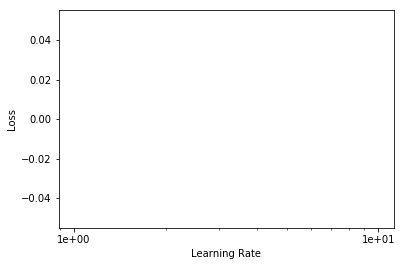

In [18]:
learn = create_learner(data, modeltype=models.resnet50)
learn.load('resnet50-stage1-bestmodel')
learn.callback_fns = [Recorder]  # Need to flush callbacks or else lr_find crashes    
learn.lr_find()
learn.recorder.plot()

Reload the transfer learning results, unfreeze, and train using the range of learning rates.

Total time: 1:29:20
epoch  train_loss  valid_loss  error_rate
1      0.177949    0.129672    0.045240    (29:48)
2      0.147390    0.113983    0.039163    (29:45)
3      0.144038    0.103827    0.037306    (29:45)



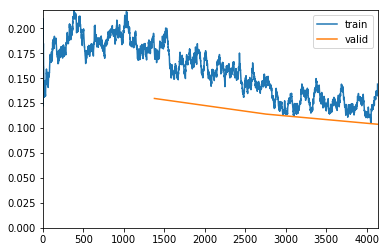

In [19]:
# Reload with new savename
learn = create_learner(data, 'resnet50-stage2-bestmodel', modeltype=models.resnet50)
learn.load('resnet50-stage1-bestmodel')

# Unfreeze and kick off 
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [20]:
results_test, y_true, y_pred, scores, class_labels = util.eval_rollup(labels_file, learn, evalset='test')

Dataset: test
{'sklearn': {'acc': 0.9592,
             'auc_avg': 0.9988975,
             'auc_indiv': array([0.999492, 0.999409, 0.998849, 0.996341, 0.999345, 0.997726, 0.99967 , 0.999517, 0.999673, 0.998953]),
             'confmat': array([[967,   3,   8,   2, ...,   0,   1,  11,   6],
       [  3, 978,   1,   0, ...,   0,   0,   4,  14],
       [  7,   0, 945,  16, ...,   8,   1,   3,   0],
       [  1,   0,   8, 923, ...,   6,   2,   2,   1],
       ...,
       [  3,   0,   5,   6, ..., 980,   0,   0,   1],
       [  4,   1,   3,   4, ...,   0, 965,   0,   1],
       [ 11,   4,   1,   0, ...,   0,   0, 983,   1],
       [  5,  32,   0,   0, ...,   0,   0,   3, 960]]),
             'report': '             precision    recall  f1-score   support\n'
                       '\n'
                       '          0       0.96      0.97      0.97      1000\n'
                       '          1       0.96      0.98      0.97      1000\n'
                       '          2       0.96    